In [373]:
import pandas as pd
import numpy as np
import os
import uuid
import re
import time
import logging

import requests
import json
import pickle

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt

import multiprocessing
import nltk.data
from nltk.tokenize import word_tokenize
from gensim.models import word2vec 
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from wordcloud import WordCloud, ImageColorGenerator

In [148]:
search_terms = ['hana']
# search_terms = ['tokyo']

In [149]:
for term in search_terms:
    filename = term + '.tsv'
    with open(filename, 'r') as f:
        mylist = [line.rstrip('\n') for line in f]
        mylist = mylist[1:]
        splitlist = [i.split('\t') for i in mylist]
        

In [150]:
hana_dict = {}


for thread in splitlist:
    unique_key = str(uuid.uuid1())
    hana_dict[unique_key] = {}
    hana_dict[unique_key]['initial_title'] = thread[0]
    hana_dict[unique_key]['comment_hierarchy'] = thread[1]
    hana_dict[unique_key]['userhandle']=thread[2]
    hana_dict[unique_key]['comment_popularity']=thread[3]
    hana_dict[unique_key]['user_post']=thread[4]
    hana_dict[unique_key]['comment_date']=thread[5]

In [46]:
tokyo_dict = {}


for thread in splitlist:
    unique_key = str(uuid.uuid1())
    tokyo_dict[unique_key] = {}
    tokyo_dict[unique_key]['initial_title'] = thread[0]
    tokyo_dict[unique_key]['comment_hierarchy'] = thread[1]
    tokyo_dict[unique_key]['userhandle']=thread[2]
    tokyo_dict[unique_key]['comment_popularity']=thread[3]
    tokyo_dict[unique_key]['user_post']=thread[4]
    tokyo_dict[unique_key]['comment_date']=thread[5]

In [151]:
hana_kimura = pd.DataFrame.from_dict(hana_dict,orient='index').reset_index()
tokyo = pd.DataFrame.from_dict(tokyo_dict,orient='index').reset_index()
tokyo =tokyo.iloc[1:]

In [153]:
hana_kimura.shape

(9127, 7)

In [377]:
tokyo.shape

(18725, 7)

In [154]:
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sia = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sia.polarity_scores(sentence) 
    
    neg = sentiment_dict['neg']*100
    neu = sentiment_dict['neu']*100
    pos = sentiment_dict['pos']*100
    compound_score = sentiment_dict['compound']
    return neg, neu, pos, compound_score

In [155]:
sentiment_score = pd.DataFrame([hana_kimura['index'][number], user_post, sentiment_scores(user_post)] for number, user_post in enumerate(hana_kimura.user_post))


In [160]:
sentiment_score_output = sentiment_score
sentiment_score_output.columns = ['index','user_post','vader']
sentiment_score_output['neg'] = [score[0] for score in sentiment_score_output.vader]
sentiment_score_output['neu'] = [score[1] for score in sentiment_score_output.vader]
sentiment_score_output['pos'] = [score[2] for score in sentiment_score_output.vader]
sentiment_score_output['cpd'] = [score[3] for score in sentiment_score_output.vader]

In [161]:
sentiment_score_output.head()

,index,user_post,vader,neg,neu,pos,cpd
0,ca7774ae-a261-11ea-9c2e-8c85902f88ef,##**If you are having a crisis or need to spea...,"(18.2, 66.60000000000001, 15.2, -0.9846)",18.2,66.6,15.2,-0.9846
1,ca7775ee-a261-11ea-8282-8c85902f88ef,[removed],"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0000
2,ca777666-a261-11ea-9767-8c85902f88ef,"no no no no no no nooh my god, I thought she ...","(0.0, 51.0, 49.0, 0.8196)",0.0,51.0,49.0,0.8196
3,ca7776c0-a261-11ea-8142-8c85902f88ef,seriously wtf i thought that tweet from earlie...,"(42.0, 52.400000000000006, 5.5, -0.9159)",42.0,52.4,5.5,-0.9159
4,ca777710-a261-11ea-8340-8c85902f88ef,I'm guessing she tried again after convincing ...,"(0.0, 66.2, 33.800000000000004, 0.5574)",0.0,66.2,33.8,0.5574


In [234]:
ss = pd.merge(hana_kimura, sentiment_score_output, how='left', on=['index','user_post'])

In [235]:
ss[ss['comment_date'].str.contains('I was very happy when you confided in me about', regex=True, case=False)]
ss = ss.drop(index=3849)

In [236]:
ss[(ss['cpd']<=-0.05) | (ss['cpd']>=0.05)].shape

(7494, 12)

In [249]:
def detect_final_sentiment(cpd):
    if cpd < 0.05 and cpd > -0.05:
        final = 'neu'
    elif cpd < -0.05:
        final = 'neg'
    else:
        final = 'pos'
    return final

In [250]:
ss['final_sentiment'] = ss.cpd.apply(lambda x: detect_final_sentiment(x))

In [251]:
ss.shape
ss.head()

,index,initial_title,comment_hierarchy,userhandle,comment_popularity,user_post,comment_date,vader,neg,neu,pos,cpd,final_sentiment
0,ca7774ae-a261-11ea-9c2e-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,rehlee,1 points,##**If you are having a crisis or need to spea...,2020-05-23,"(18.2, 66.60000000000001, 15.2, -0.9846)",18.2,66.6,15.2,-0.9846,neg
1,ca7775ee-a261-11ea-8282-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,None,-2 points,[removed],2020-05-23,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0000,neu
2,ca777666-a261-11ea-9767-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,pinaynoire,480 points,"no no no no no no nooh my god, I thought she ...",2020-05-23,"(0.0, 51.0, 49.0, 0.8196)",0.0,51.0,49.0,0.8196,pos
3,ca7776c0-a261-11ea-8142-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 2,jookz,196 points,seriously wtf i thought that tweet from earlie...,2020-05-23,"(42.0, 52.400000000000006, 5.5, -0.9159)",42.0,52.4,5.5,-0.9159,neg
4,ca777710-a261-11ea-8340-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 3,Gubrach,89 points,I'm guessing she tried again after convincing ...,2020-05-23,"(0.0, 66.2, 33.800000000000004, 0.5574)",0.0,66.2,33.8,0.5574,pos


In [444]:
ss.initial_title.value_counts().reset_index()['index'][1]

'[SPOILERS] Terrace House Tokyo 2019-2020 Part 4 Episode 38 "Case of The Costume Incident"'

In [252]:
fs = ss.groupby(['comment_date', 'final_sentiment'])['index'].count().reset_index()
fs.head()

,comment_date,final_sentiment,index
0,2019-11-24,neg,1
1,2019-11-24,neu,5
2,2019-11-24,pos,8
3,2019-11-25,neu,1
4,2019-11-25,pos,1


In [254]:
fsagg = pd.pivot_table(fs, values='index', index=['comment_date'],
                    columns=['final_sentiment'], aggfunc=np.sum).reset_index().fillna(0)
fsagg.head()

final_sentiment,comment_date,neg,neu,pos
0,2019-11-24,1.0,5.0,8.0
1,2019-11-25,0.0,1.0,1.0
2,2019-11-30,2.0,2.0,3.0
3,2019-12-01,0.0,1.0,0.0
4,2019-12-02,0.0,0.0,1.0


In [262]:
fsagg['total'] = fsagg['neg'] + fsagg['neu'] + fsagg['pos']
fsagg['neg_perc'] = round(fsagg['neg'] * 1 / fsagg['total'],2)
fsagg['pos_perc'] = round(fsagg['pos'] * 1 / fsagg['total'],2)

In [263]:
fsagg.head()
fsagg.to_csv('negative_share.csv')

final_sentiment,comment_date,neg,neu,pos,total,neg_perc,pos_perc
0,2019-11-24,1.0,5.0,8.0,14.0,0.07,0.57
1,2019-11-25,0.0,1.0,1.0,2.0,0.00,0.50
2,2019-11-30,2.0,2.0,3.0,7.0,0.29,0.43
3,2019-12-01,0.0,1.0,0.0,1.0,0.00,0.00
4,2019-12-02,0.0,0.0,1.0,1.0,0.00,1.00


In [266]:
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leongjiams/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [341]:
def clean_text(df):
    cleaned_message = []
    for pos in range(df.shape[0]):
        val = df.iloc[pos]['user_post']
        
        #Normalize tabs and remove newlines
        no_tabs = str(val).replace('\t', ' ').replace('\n', '').replace('"', '').replace("'", '').strip().lower()
        
        #Remove all characters except A-Z and a dot.
        alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs)
        
        #Normalize spaces to 1
        multi_spaces = re.sub(" +", " ", alphas_only)
        
        #Get sentences from the tokenizer, remove the dot in each.
        sentences = tokenizer.tokenize(multi_spaces)
        sentences = [re.sub("[\.]", "", sentence) for sentence in sentences]
        try: 
            sentences = word_tokenize(sentences[0])
        except:
            print(sentences)
        cleaned_message.append(sentences)
    return cleaned_message

In [344]:
ss_neg= ss[ss['final_sentiment'] == 'neg']
print(ss_neg.shape)

clean = clean_text(ss)

(3465, 13)
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [345]:
clean[:10]

[['if',
  'you',
  'are',
  'having',
  'a',
  'crisis',
  'or',
  'need',
  'to',
  'speak',
  'to',
  'someone',
  'please',
  'call',
  'the',
  'number',
  'below',
  'for',
  'your',
  'location'],
 ['removed'],
 ['no',
  'no',
  'no',
  'no',
  'no',
  'no',
  'nooh',
  'my',
  'god',
  'i',
  'thought',
  'she',
  'was',
  'going',
  'to',
  'be',
  'okayrip',
  'hana'],
 ['seriously',
  'wtf',
  'i',
  'thought',
  'that',
  'tweet',
  'from',
  'earlier',
  'today',
  'said',
  'people',
  'went',
  'to',
  'hana',
  'and',
  'she',
  'was',
  'fine',
  'wtf',
  'happened',
  'so',
  'sad'],
 ['im',
  'guessing',
  'she',
  'tried',
  'again',
  'after',
  'convincing',
  'people',
  'she',
  'was',
  'okay'],
 ['i',
  'hadn',
  't',
  'even',
  'seen',
  'this',
  'thread',
  'rather',
  'i',
  'saw',
  'the',
  'one',
  'of',
  'reo',
  's',
  'post',
  'on',
  'my',
  'main',
  'feed'],
 ['thats', 'the', 'same', 'thing', 'i', 'thought'],
 ['what', 'tweet', 'is', 'this'],
 [

In [378]:
start = time.time()

#Set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

# Set values for various parameters
num_features = 512    # Dimensionality of the hidden layer representation
min_word_count = 50   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count()       # Number of threads to run in parallel set to total number of cpus.
context = 10         # Context window size (on each side)                                                       
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. 
#The LineSentence object allows us to pass in a file name directly as input to Word2Vec,
#instead of having to read it into memory first.
print("Training model...")
model = word2vec.Word2Vec(clean, workers=num_workers,
            size=num_features, min_count = min_word_count,
            window = context, sample = downsampling)

# We don't plan on training the model any further, so calling 
# init_sims will make the model more memory efficient by normalizing the vectors in-place.
model.init_sims(replace=True)

# Save the model
model_name = 'hana_kimura'
model.save(model_name)
print('Total time: ' + str((time.time() - start)) + ' secs')

Training model...
Total time: 0.5729248523712158 secs


In [379]:
Z = model.wv.syn0;
print(Z[0].shape)
Z[0]

(512,)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


array([ 3.76221500e-02, -3.41834202e-02,  4.49003093e-03,  1.17214043e-02,
       -2.15961970e-03,  5.68282744e-03, -4.01900075e-02, -1.85808912e-02,
        7.06801889e-04,  2.40675509e-02, -3.62924933e-02,  1.62622128e-02,
        5.87665895e-03, -1.84373297e-02,  9.90409032e-03,  4.82396521e-02,
       -3.97154763e-02, -1.02017723e-01,  8.53798762e-02,  6.52960688e-02,
        3.47387791e-02, -2.09419411e-02,  5.86871020e-02,  3.05880327e-02,
       -5.33629656e-02, -7.27711916e-02, -2.07490176e-02, -9.24110413e-02,
        4.79683839e-02, -7.24254176e-02,  2.25745188e-03, -5.24933338e-02,
       -1.15394741e-02,  1.28835782e-01,  1.13461226e-01, -6.85910434e-02,
       -2.17017829e-02,  5.43311164e-02,  3.72696817e-02,  1.36145670e-02,
       -4.54739705e-02,  3.97635177e-02, -6.49758503e-02, -3.36806662e-02,
        1.39355725e-02,  4.65432964e-02, -8.41887947e-03, -8.21436942e-03,
        3.27924662e-03,  7.31552243e-02,  3.72147597e-02, -4.62350016e-03,
       -5.60513791e-03,  

In [371]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


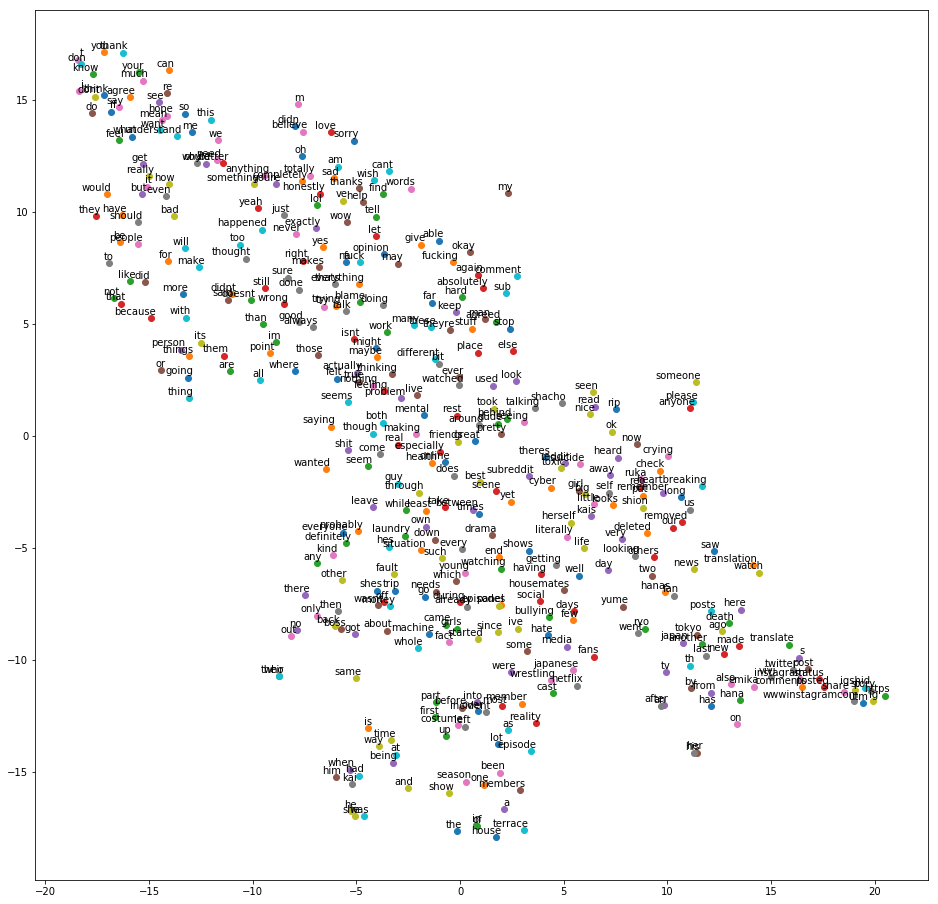

In [380]:
tsne_plot(model)

In [348]:
Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Z)
    Sum_of_squared_distances.append(km.inertia_)

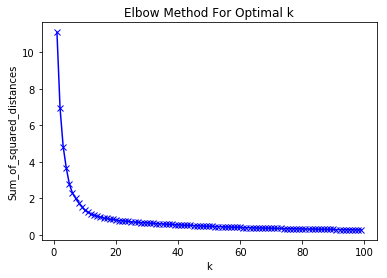

In [349]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [350]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++')
    idx = kmeans_clustering.fit_predict(word_vectors)
    
    return kmeans_clustering.cluster_centers_, idx

In [351]:
centers, clusters = clustering_on_wordvecs(Z, 20)
centroid_map = dict(zip(model.wv.index2word, clusters))

In [352]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs)
    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers]
    closest_words_idxs = [x[1] for x in closest_points]
    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {}
    
    for i in range(0, len(closest_words_idxs)):
        closest_words[str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df

In [355]:
top_words = get_top_words(model.wv.index2word, 50, centers, Z)
top_words

,0,1,10,11,12,13,14,15,16,17,18,19,2,3,4,5,6,7,8,9
1,washer,reddit,source,on,feel,yeah,behind,from,poor,okay,know,https,mean,i,terrace,house,in,took,wish,by
2,during,stuff,igshid,a,agree,but,real,at,women,wait,think,wwwinstagramcom,if,dont,the,of,of,seriously,anything,after
3,front,times,stories,and,do,why,thread,one,literally,exactly,dont,p,understand,you,in,the,the,either,honestly,time
4,over,especially,utm,one,can,like,online,show,mind,let,don,story,want,know,members,in,on,feeling,cant,th
5,netflix,peppe,twittercom,show,see,could,making,season,hes,wouldnt,i,ig,hope,t,of,on,a,kinda,believe,tv
6,housemates,kais,status,from,if,get,behavior,time,etc,miss,t,instagramcom,really,think,one,show,one,hurt,remember,first
7,japanese,suicide,item,at,hope,even,shows,is,away,matter,can,comments,say,don,on,one,show,close,couldn,my
8,incident,argument,wwwredditcom,his,understand,how,years,and,today,imagine,you,from,see,can,a,a,members,myself,totally,reality
9,bullying,type,instagramcom,lot,really,believe,days,by,lost,truly,agree,on,what,agree,show,from,and,die,re,being
10,whole,harsh,r,her,mean,didnt,line,has,personal,glad,do,utm,m,do,at,members,from,everything,oh,their


In [356]:
top_words.to_csv('hana_kimura_topics.csv')

In [357]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [358]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(Z)
distances, indices = nbrs.kneighbors(Z)

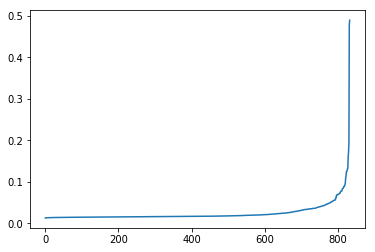

In [359]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [366]:
m = DBSCAN(eps=0.05, min_samples=5)
m.fit(Z)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [367]:
clusters = m.labels_

In [368]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

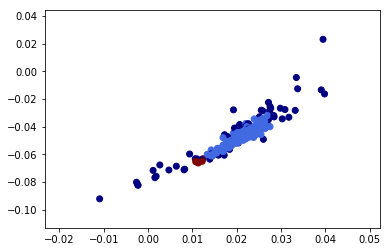

In [369]:
plt.scatter(Z[:,0], Z[:,1], c=vectorizer(clusters))

In [370]:
clusters 

array([-1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0,  0,  0, -1, -1,  0,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0,  0,  1, -1, -1, -1, -1,  0,  0,  1,  0, -1,  0,  0, -1,
        0,  0,  0,  0, -1, -1,  0, -1, -1,  0,  0, -1, -1, -1,  0, -1,  0,
       -1,  0, -1, -1,  0, -1, -1,  0, -1,  0,  0,  0,  0, -1,  0,  0, -1,
       -1,  0,  0,  0, -1,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [426]:
spotlight = ss[ss['comment_date'] == '2020-03-31'].sort_values(by='cpd', ascending=True)
spotlight['round_cpd'] = round(spotlight.cpd,1)

In [433]:
spotlight = ss[ss['comment_date'] == '2020-03-31'].sort_values(by='cpd', ascending=False)

7440    I wish I could say I was shocked at Hana and K...
8594    I think this is the most level-headed comment ...
7585    The costume thing has me fuming with the hypoc...
8351    It is funny Hana is talking about being consid...
7446    Yeah I don’t really know how to describe it ei...
Name: user_post, dtype: object

In [430]:
spotlight_groupby = spotlight.groupby(['round_cpd'])['cpd'].count()
spotlight_groupby.reset_index().to_csv('polarising_groups.csv')

In [440]:
spotlight_news = ss[ss['comment_date'] == '2020-05-24'].sort_values(by='cpd', ascending=True)
spotlight_news['round_cpd'] = round(spotlight_news.cpd,1)
spotlight_news_groupby = spotlight_news.groupby(['round_cpd'])['cpd'].count()

In [442]:
spotlight_news_groupby.to_csv('spotlight_news_groupby.csv')

In [445]:
spotlight_news_groupby

round_cpd
-1.0     95
-0.9    150
-0.8    115
-0.7     73
-0.6     80
-0.5     77
-0.4     70
-0.3     55
-0.2     49
-0.1     32
-0.0    312
 0.1     36
 0.2     48
 0.3     72
 0.4     92
 0.5     57
 0.6     79
 0.7     70
 0.8    102
 0.9    135
 1.0     67
Name: cpd, dtype: int64

In [446]:
ss[ss['cpd'] == 0]

,index,initial_title,comment_hierarchy,userhandle,comment_popularity,user_post,comment_date,vader,neg,neu,pos,cpd,final_sentiment,round_cpd
1,ca7775ee-a261-11ea-8282-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,None,-2 points,[removed],2020-05-23,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
6,ca7777a6-a261-11ea-a9e0-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,SteinSteenStern,4 points,thats the same thing I thought,2020-05-24,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
7,ca7777ec-a261-11ea-bfc4-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,razolly,9 points,What tweet is this?,2020-05-23,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
8,ca777834-a261-11ea-bb71-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,captainabsolutus,8 points,[this is what I saw](https://mobile.twitter.co...,2020-05-24,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
9,ca777878-a261-11ea-b977-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,F1NANCE,3 points,There was a thread about it,2020-05-23,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
11,ca77790c-a261-11ea-911d-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,setzsetz,0 points,The backlash she received stems from the more ...,2020-05-24,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
16,ca777a6c-a261-11ea-91c1-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 2,spacejam999,8 points,Wait what happened exactly? Can someone explain?,2020-05-24,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
33,ca777f12-a261-11ea-8efb-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,Blakeeeeh,7 points,People obviously weren’t reasonable about it o...,2020-05-24,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
37,ca77801e-a261-11ea-8ca2-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,Blakeeeeh,1 points,Amen.,2020-05-24,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
40,ca7780f4-a261-11ea-822f-8c85902f88ef,Hana Kimura has passed away (Official announce...,level 1,tabristheok,11 points,More people need to see this post,2020-05-24,"(0.0, 100.0, 0.0, 0.0)",0.0,100.0,0.0,0.0,neu,0.0
